In [1]:
import pandas as pd
import numpy as np
import os
import sys

#!pip install librosa
#!pip install lifelines
#!pip install np_utils
#!pip install tensorflow
#!pip install -q -U keras-tuner

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

## Importing and Splitting the datasets

In [2]:
#importing the datasets (train_set_augmented for all landmarks, train_set_augmented_simplified for simplified landmarks)
train_set = pd.read_csv('outputs/train_set_augmented_simplified.csv')
test_set = pd.read_csv('outputs/test_set_augmented_simplified.csv')

In [3]:
#Split into features and target; x = features, y = target
x_train = train_set.iloc[:, 1:]
y_train = train_set['label']

x_test = test_set.iloc[:, 1:]
y_test = test_set['label']

In [4]:
x_test

,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,lm_4_x,...,lm_138_z,lm_139_x,lm_139_y,lm_139_z,lm_140_x,lm_140_y,lm_140_z,lm_141_x,lm_141_y,lm_141_z
0,0.207841,0.427158,-0.052541,0.249446,0.397158,-0.077840,0.304518,0.374407,-0.092454,0.375054,...,0.072984,0.479263,0.637998,-0.092606,0.610292,0.589869,-0.167392,0.666678,0.605170,-0.038013
1,0.294301,0.412844,0.098371,0.304432,0.391542,0.061842,0.325369,0.377782,0.027234,0.361403,...,-0.015569,0.391587,0.629452,-0.042867,0.441692,0.601849,-0.141174,0.548979,0.625148,-0.078085
2,0.246525,0.321810,-0.078775,0.290492,0.299129,-0.114281,0.346424,0.286425,-0.139784,0.412982,...,0.002694,0.441087,0.615499,-0.066547,0.556802,0.607764,-0.154507,0.615264,0.614899,-0.033336
3,0.217589,0.364185,-0.014838,0.241245,0.342264,-0.057201,0.280000,0.326760,-0.091014,0.335223,...,-0.001676,0.426119,0.614159,-0.055244,0.520120,0.597505,-0.160186,0.608256,0.583230,-0.053283
4,0.164340,0.356398,-0.018963,0.203008,0.323254,-0.061714,0.261160,0.298875,-0.090613,0.337455,...,0.027649,0.423200,0.614284,-0.098031,0.556574,0.575104,-0.208170,0.651104,0.600559,-0.071470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6162,0.191135,0.237120,0.031330,0.228589,0.213849,-0.017328,0.280645,0.208135,-0.056963,0.347044,...,0.004447,0.348511,0.617055,-0.068857,0.444250,0.595785,-0.192212,0.536449,0.650053,-0.069122
6163,0.319695,0.341893,0.087654,0.341282,0.324483,0.052740,0.373991,0.316708,0.023168,0.417257,...,0.014327,0.413731,0.558450,-0.045354,0.479573,0.533246,-0.135318,0.556602,0.580762,-0.062900
6164,0.303098,0.359674,0.028591,0.332309,0.342821,0.002461,0.369429,0.335559,-0.019071,0.415883,...,0.020695,0.407209,0.611315,-0.049905,0.481565,0.592153,-0.122091,0.536967,0.636595,-0.044345
6165,0.308434,0.375892,0.019520,0.327328,0.367571,-0.016187,0.358332,0.369528,-0.047132,0.398065,...,-0.030084,0.398634,0.585848,-0.035666,0.452111,0.585416,-0.124202,0.521738,0.618270,-0.049547


In [5]:
y_test

0         happy
1         happy
2         happy
3         happy
4         happy
         ...   
6162    neutral
6163    neutral
6164    neutral
6165    neutral
6166    neutral
Name: label, Length: 6167, dtype: object

In [6]:
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#Get the labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

y_test

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [7]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((28263, 423, 1), (28263, 4), (6167, 423, 1), (6167, 4))

## Hyperparameter Tuning



In [9]:
input_shape = (x_train.shape[1], 1)

In [10]:
def hypo_tuning_model(hp):
    model= Sequential()

    hp_layer_1 = hp.Int('layer_1', min_value=32, max_value=512, step=32)
    hp_layer_2 = hp.Int('layer_2', min_value=32, max_value=256, step=32)
    hp_layer_3 = hp.Int('layer_3', min_value=32, max_value=128, step=32)
    hp_layer_4 = hp.Int('layer_4', min_value=32, max_value=64, step=32)
    hp_layer_dense = hp.Int('layer_dense', min_value=32, max_value=64, step=32)
    
    hp_layers_kernel = hp.Int('layer_kernel_size', min_value=1, max_value=7, step=2)
    hp_layers_strides = hp.Int('layer_strides', min_value=1, max_value=3, step=1)
    
    hp_layers_pool_size = hp.Int('max_pooling_pool_size', min_value=1, max_value=7, step=2)
    hp_layers_strides = hp.Int('max_pooling_strides', min_value=1, max_value=3, step=1)

    hp_layers_dropout = hp.Float('layer_dropout', min_value=0.05, max_value=0.3, step=0.05)
    hp_layers_dense_dropout = hp.Float('layer_dense_dropout', min_value=0.05, max_value=0.3, step=0.05)
    
    model.add(Conv1D(filters=hp_layer_1, kernel_size=hp_layers_kernel, strides=hp_layers_strides, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=hp_layers_pool_size, strides=hp_layers_strides, padding = 'same'))

    model.add(Conv1D(filters=hp_layer_2, kernel_size=hp_layers_kernel, strides=hp_layers_strides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=hp_layers_pool_size, strides=hp_layers_strides, padding = 'same'))
    model.add(Dropout(hp_layers_dropout))
    
    model.add(Conv1D(filters=hp_layer_3, kernel_size=hp_layers_kernel, strides=hp_layers_strides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=hp_layers_pool_size, strides=hp_layers_strides, padding = 'same'))
    model.add(Dropout(hp_layers_dropout))
    
    model.add(Conv1D(filters=hp_layer_4, kernel_size=hp_layers_kernel, strides=hp_layers_strides, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=hp_layers_pool_size, strides=hp_layers_strides, padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(units=hp_layer_dense, activation='relu'))
    model.add(Dense(units=hp_layer_dense, activation='relu'))
    model.add(Dense(units=hp_layer_dense, activation='relu'))
    model.add(Dropout(hp_layers_dense_dropout))
    
    model.add(Dense(units=4, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [11]:
import keras_tuner as kt

tuner = kt.Hyperband(hypo_tuning_model,
                     objective='val_accuracy',
                     max_epochs=11,
                     factor=3,
                     directory='dir',
                     project_name='simp')

Reloading Tuner from dir\simp\tuner0.json


In [12]:
folder = 'simp/ckpt_cnn'
checkpoint_filepath = os.getcwd() + '/' + folder + '/Epoch{epoch:02d}_{accuracy:.2f}.keras'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max')

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.8, verbose=1, patience=2, min_lr=0.0001)

In [13]:
tuner.search(x_train, y_train, batch_size=64, epochs=11, validation_data=(x_test, y_test), callbacks=[model_checkpoint_callback, early_stopping_callback, rlrp])

Trial 30 Complete [00h 07m 20s]
val_accuracy: 0.4686233103275299

Best val_accuracy So Far: 0.7713637351989746
Total elapsed time: 02h 05m 22s


In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps

## Model Training

In [15]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 423, 320)          1920      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 423, 320)          0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 423, 96)           153696    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 423, 96)           0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 423, 96)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 423, 32)          

In [16]:
def train_model(model, folder, x_train, y_train, x_test, y_test):
    checkpoint_filepath = os.getcwd() + '/' + folder + '/Epoch{epoch:02d}_{accuracy:.2f}.keras'
    
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max')

    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.8, verbose=1, patience=2, min_lr=0.0001)

    history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[model_checkpoint_callback, early_stopping_callback, rlrp])
    return history

In [17]:
history = train_model(model, folder,  x_train, y_train, x_test, y_test)

Epoch 1/50
442/442 [==============================] - 149s 266ms/step - loss: 0.9163 - accuracy: 0.6090 - val_loss: 0.7521 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 2/50
442/442 [==============================] - 114s 258ms/step - loss: 0.7732 - accuracy: 0.6885 - val_loss: 0.6840 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 3/50
442/442 [==============================] - 112s 254ms/step - loss: 0.7150 - accuracy: 0.7146 - val_loss: 0.6534 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 4/50
442/442 [==============================] - 84s 189ms/step - loss: 0.6715 - accuracy: 0.7354 - val_loss: 0.6375 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 5/50
442/442 [==============================] - 96s 218ms/step - loss: 0.6434 - accuracy: 0.7455 - val_loss: 0.6198 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 6/50
442/442 [==============================] - 96s 217ms/step - loss: 0.6205 - accuracy: 0.7535 - val_loss: 0.5795 - val_accuracy: 0.7659 - lr: 0.0010
Epoch 7/50
442/442 [=============================

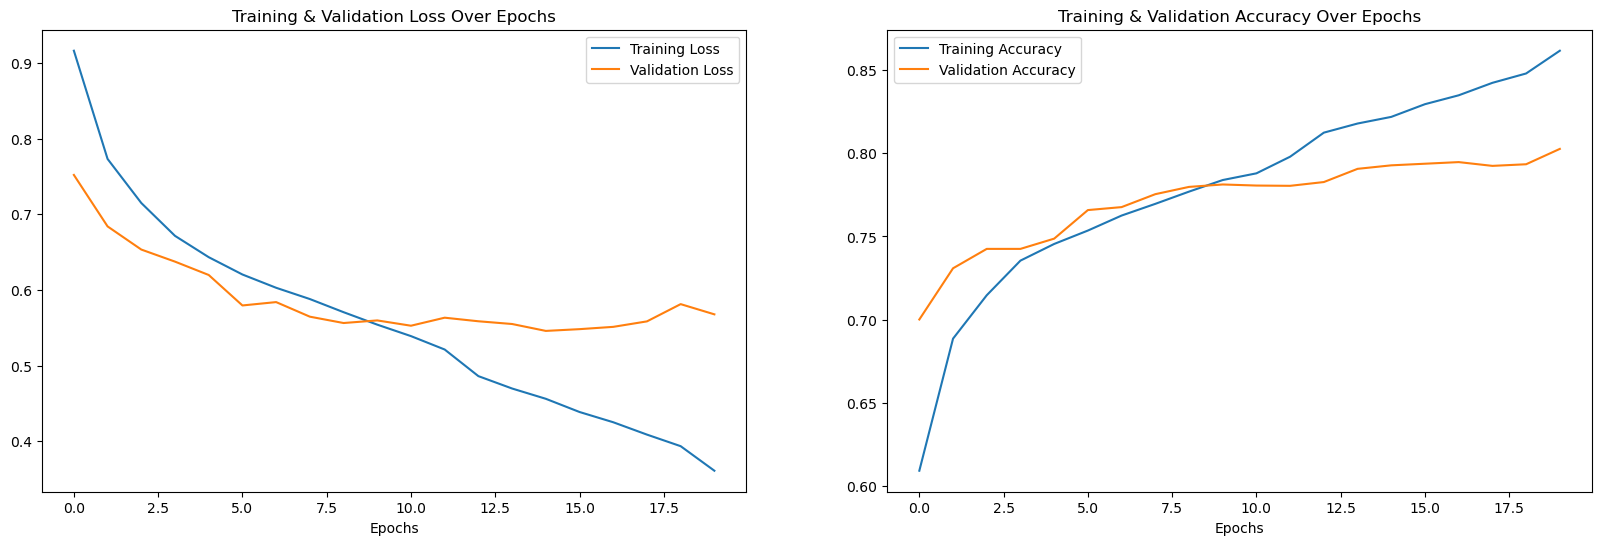

In [18]:
epochs = [i for i in range(len(history.history['accuracy']))]
fig, ax = plt.subplots(1,2)
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
test_accuracy = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss, label = 'Training Loss')
ax[0].plot(epochs, test_loss, label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss Over Epochs')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_accuracy, label = 'Training Accuracy')
ax[1].plot(epochs, test_accuracy, label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy Over Epochs')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [19]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

193/193 [==============================] - 10s 41ms/step


In [20]:
y_pred

array([['anger'],
       ['happy'],
       ['happy'],
       ...,
       ['sad'],
       ['sad'],
       ['neutral']], dtype=object)

        anger happy neutral   sad
anger    1207    46     204   160
happy      32  1648      43    45
neutral    97    35    1074   173
sad       128    53     201  1021


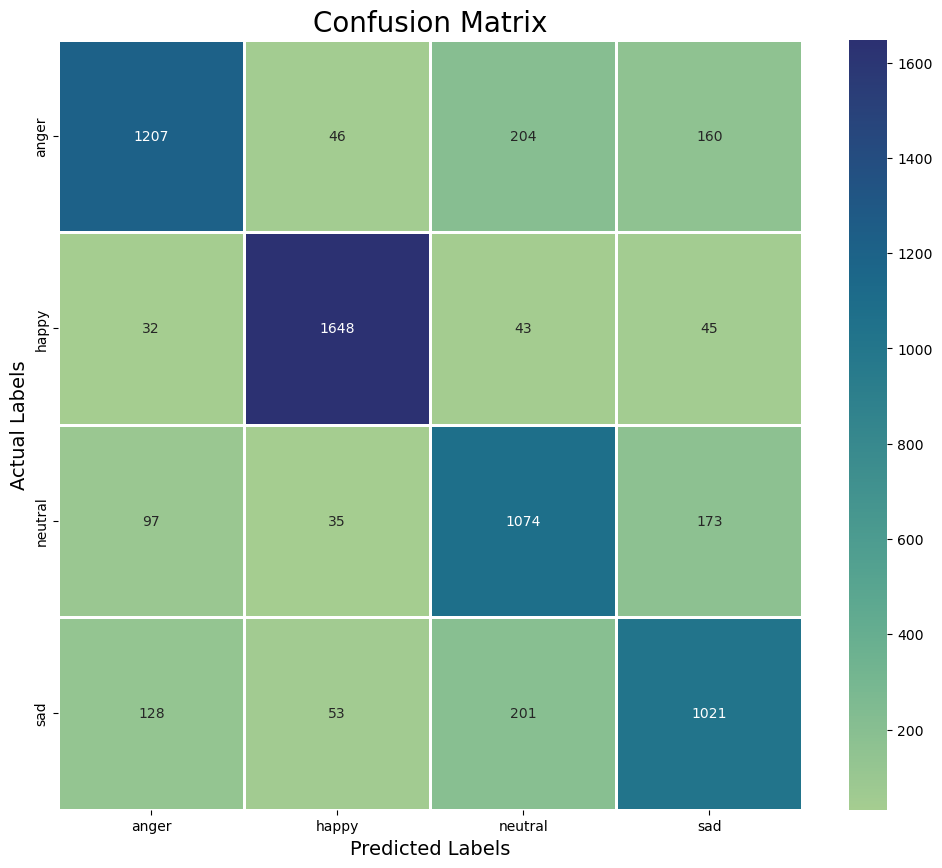

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='crest', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
print(cm)
plt.show()

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

acs_test = accuracy_score(y_test,y_pred)
ps_test = precision_score(y_test,y_pred, average = "macro")
rs_test = recall_score(y_test,y_pred,  average = "macro")
fs_test = f1_score(y_test,y_pred,  average = "macro")

print("Accuracy Score: ", "{:.2%}".format(acs_test))
print("Precision Score: ", "{:.2%}".format(ps_test))
print("Recall Score: ", "{:.2%}".format(rs_test))
print("F1 Score: ", "{:.2%}".format(fs_test))

Accuracy Score:  80.27%
Precision Score:  79.62%
Recall Score:  79.63%
F1 Score:  79.53%


In [23]:
#K fold Cross Validation Module

#1. Get all rows together
all_data_df = pd.concat([train_set, test_set])
num_rows = len(all_data_df.index)

In [24]:
#2. Shuffle rows
all_data_df = all_data_df.sample(frac=1).reset_index()
all_data_df = all_data_df.drop(columns=['index'])    

In [25]:
#K fold cross validation for k=5 (5 runs)
fold_num_rows = num_rows // 5
last_fold_num_rows = num_rows - (fold_num_rows * 4)

confusion_matrices = []
scores = []
for i in range(0, 5):
    #Get number of rows to retrieve
    start = i * fold_num_rows
    end = (i + 1) * fold_num_rows
    if i == 4:
        end = num_rows

    print("K =", str(i+1), "getting images from", str(start), "to", str(end))
    
    #Construct train and test split using iloc
    test_df = all_data_df.iloc[start:end, : ]
    train_df = pd.concat([all_data_df, test_df]).drop_duplicates(keep=False)

    x_train = train_df.iloc[:, 1:]
    y_train = train_df['label']
    
    x_test = test_df.iloc[:, 1:]
    y_test = test_df['label']

    encoder = OneHotEncoder()
    y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
    y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    x_train = np.expand_dims(x_train, axis=2)
    x_test = np.expand_dims(x_test, axis=2)

    #Train the model
    model = tuner.hypermodel.build(best_hps)
    history = train_model(model, 'simp/ckpt_cnn_k' + str(i+1), x_train, y_train, x_test, y_test)

    #Evaluate the model
    pred_test = model.predict(x_test)
    y_pred = encoder.inverse_transform(pred_test)
    y_test = encoder.inverse_transform(y_test)

    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
    
    acs_test = accuracy_score(y_test,y_pred)
    ps_test = precision_score(y_test,y_pred, average = "macro")
    rs_test = recall_score(y_test,y_pred,  average = "macro")
    fs_test = f1_score(y_test,y_pred,  average = "macro")

    fold_score = {
        "accuracy": acs_test,
        "precision": ps_test,
        "recall": rs_test,
        "f1": fs_test
    }

    #Save the scores
    confusion_matrices.append(cm)
    scores.append(fold_score)

K = 1 getting images from 0 to 6886
Epoch 1/50
395/395 [==============================] - 86s 166ms/step - loss: 0.9228 - accuracy: 0.6050 - val_loss: 0.8022 - val_accuracy: 0.6664 - lr: 0.0010
Epoch 2/50
395/395 [==============================] - 52s 132ms/step - loss: 0.7766 - accuracy: 0.6804 - val_loss: 0.7386 - val_accuracy: 0.7017 - lr: 0.0010
Epoch 3/50
395/395 [==============================] - 53s 135ms/step - loss: 0.7210 - accuracy: 0.7112 - val_loss: 0.6864 - val_accuracy: 0.7236 - lr: 0.0010
Epoch 4/50
395/395 [==============================] - 52s 133ms/step - loss: 0.6764 - accuracy: 0.7306 - val_loss: 0.6678 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 5/50
395/395 [==============================] - 55s 140ms/step - loss: 0.6529 - accuracy: 0.7420 - val_loss: 0.6485 - val_accuracy: 0.7324 - lr: 0.0010
Epoch 6/50
395/395 [==============================] - 66s 167ms/step - loss: 0.6333 - accuracy: 0.7533 - val_loss: 0.6212 - val_accuracy: 0.7491 - lr: 0.0010
Epoch 7/50
395/3

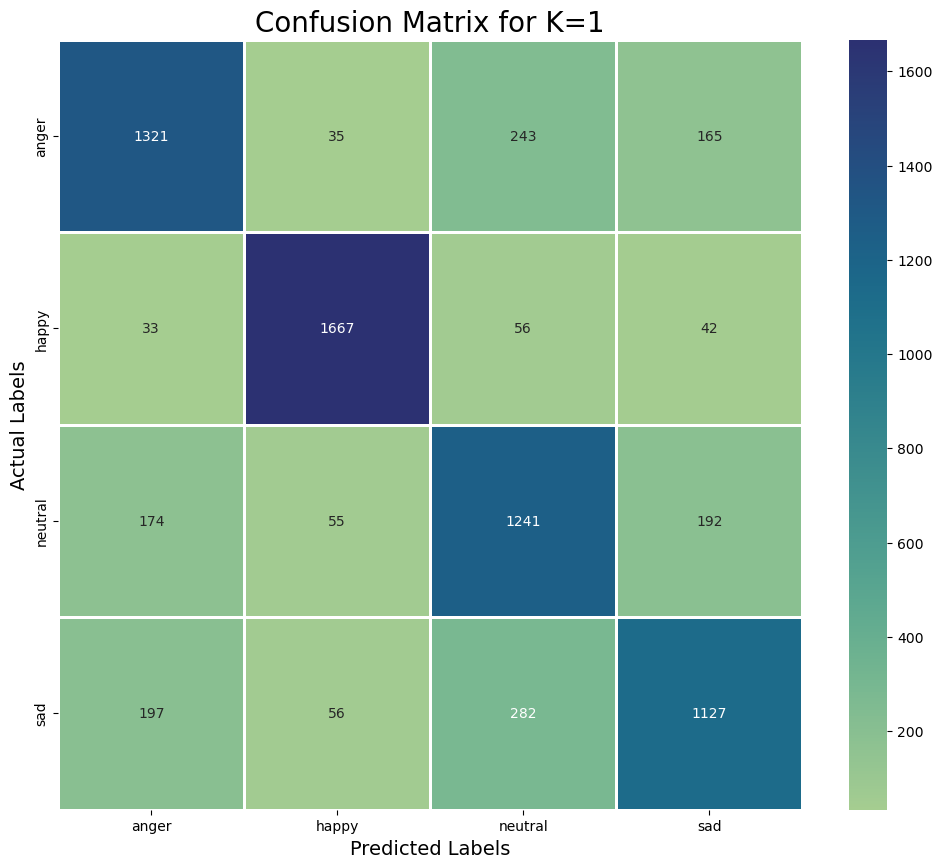

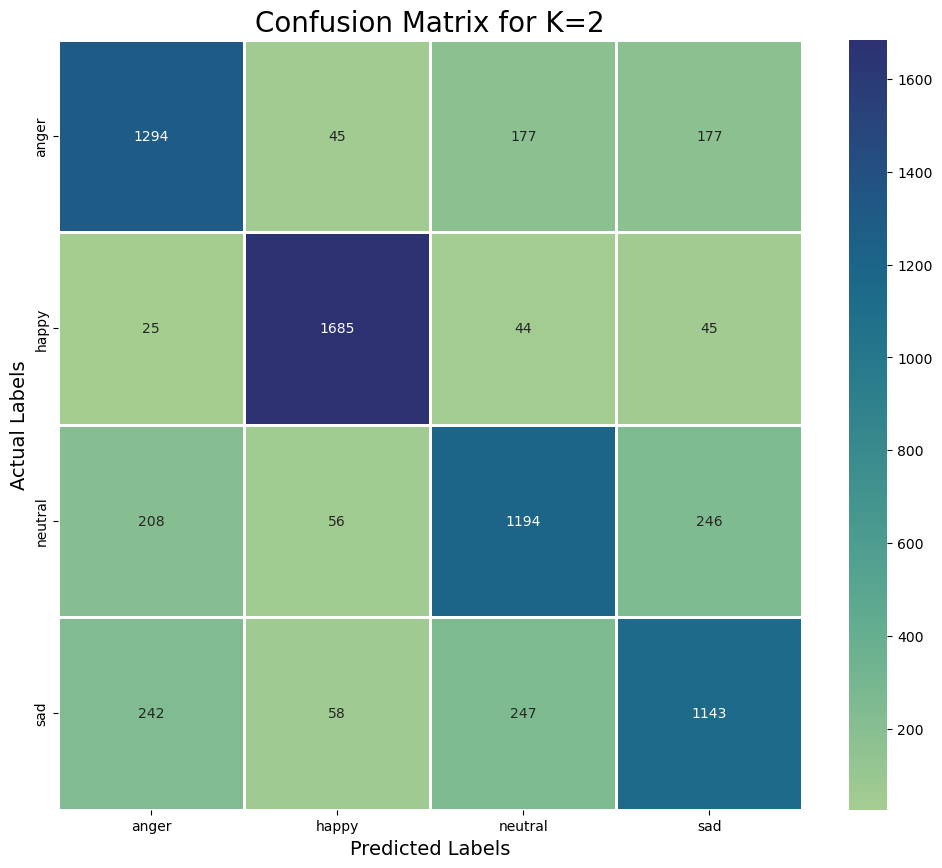

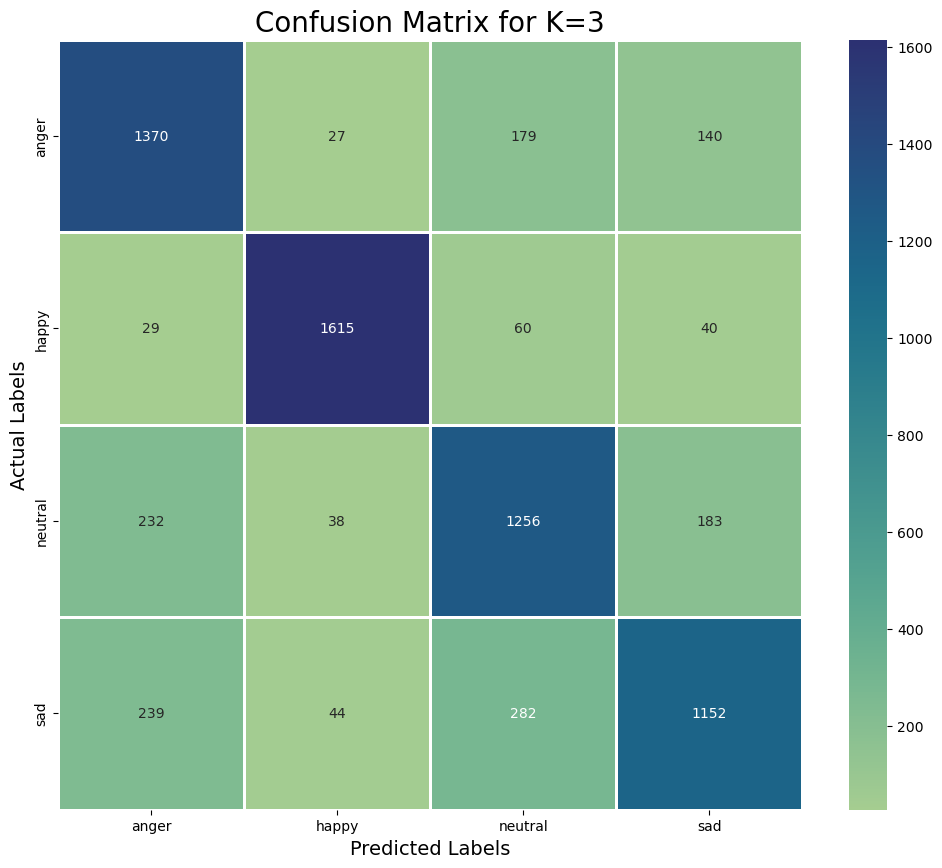

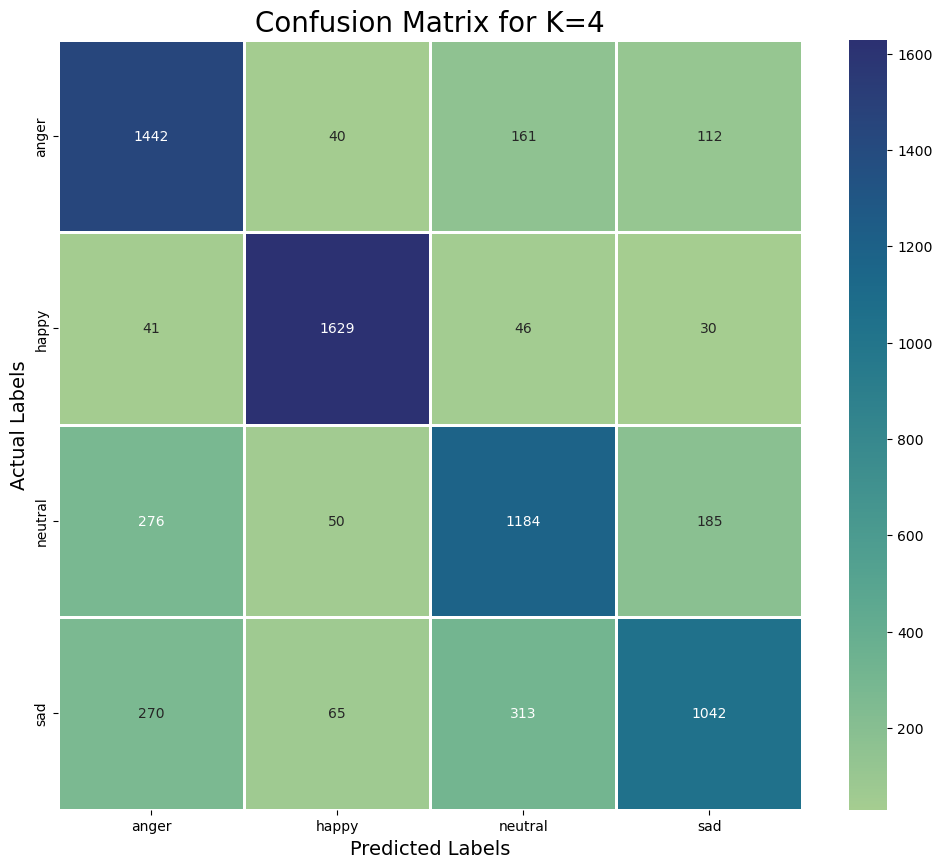

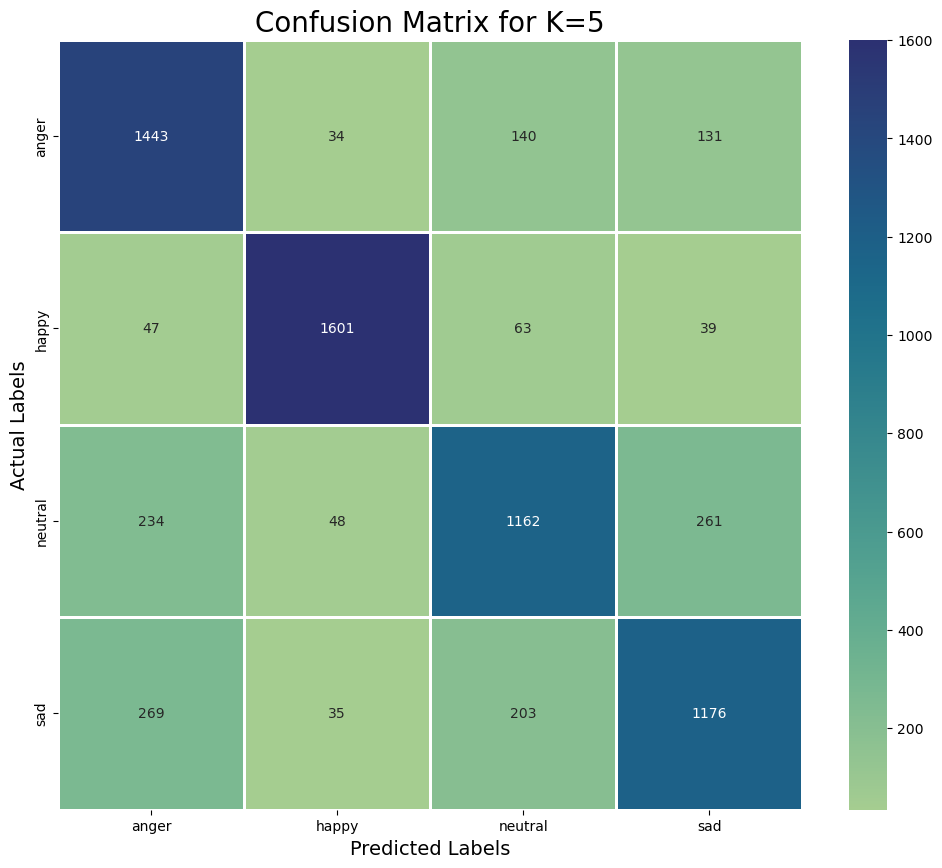

In [26]:
#Show each result in confusion matrix
for i in range(len(confusion_matrices)):
    cm = confusion_matrices[i]
    plt.figure(figsize = (12, 10))
    sns.heatmap(cm, linecolor='white', cmap='crest', linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix for K='+str(i+1), size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)

In [27]:
#Show each score and summarize results

cross_val_score = {
    "accuracy": 0,
    "precision": 0,
    "recall": 0,
    "f1": 0
}
for i in range(len(scores)):
    acs_test = scores[i]['accuracy']
    ps_test = scores[i]['precision']
    rs_test = scores[i]['recall']
    fs_test = scores[i]['f1']
    
    print("Score Summary for K =",str(i+1))
    print("Accuracy Score: ", "{:.2%}".format(acs_test))
    print("Precision Score: ", "{:.2%}".format(ps_test))
    print("Recall Score: ", "{:.2%}".format(rs_test))
    print("F1 Score: ", "{:.2%}".format(fs_test))

    cross_val_score['accuracy'] += acs_test
    cross_val_score['precision'] += ps_test
    cross_val_score['recall'] += rs_test
    cross_val_score['f1'] += fs_test

cross_val_score['accuracy'] /= 5
cross_val_score['precision'] /= 5
cross_val_score['recall'] /= 5
cross_val_score['f1'] /= 5

Score Summary for K = 1
Accuracy Score:  77.78%
Precision Score:  77.62%
Recall Score:  77.52%
F1 Score:  77.50%
Score Summary for K = 2
Accuracy Score:  77.20%
Precision Score:  76.83%
Recall Score:  76.95%
F1 Score:  76.86%
Score Summary for K = 3
Accuracy Score:  78.32%
Precision Score:  78.42%
Recall Score:  78.26%
F1 Score:  78.22%
Score Summary for K = 4
Accuracy Score:  76.92%
Precision Score:  76.99%
Recall Score:  76.74%
F1 Score:  76.58%
Score Summary for K = 5
Accuracy Score:  78.16%
Precision Score:  78.22%
Recall Score:  78.02%
F1 Score:  77.99%


In [28]:
acs_test = cross_val_score['accuracy']
ps_test = cross_val_score['precision']
rs_test = cross_val_score['recall']
fs_test = cross_val_score['f1']

print("5-Fold Cross Validation Score Summary")
print("Accuracy Score: ", "{:.2%}".format(acs_test))
print("Precision Score: ", "{:.2%}".format(ps_test))
print("Recall Score: ", "{:.2%}".format(rs_test))
print("F1 Score: ", "{:.2%}".format(fs_test))


5-Fold Cross Validation Score Summary
Accuracy Score:  77.68%
Precision Score:  77.62%
Recall Score:  77.50%
F1 Score:  77.43%
